<a href="https://colab.research.google.com/github/Untick/Marketplaces/blob/main/Shishkin%20Sergey/%D0%9F%D0%B5%D1%80%D0%B2%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D1%80%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предисловие

Предупреждение!!!
Данная работа предназначена для демонстрации возможности прогнозирования продаж на маркетплейсах на основе статистических данных(с определенными оговорками, предположениями, упрощениями и ограничениями - согласно логики и исследований автора).


Было проведено ряд экспериментов https://docs.google.com/presentation/d/1NfB9cUulHSx08ru3YuZvVLORxANSZW-5rv1rC9lLgi4/edit?usp=drive_link
Эксперименты проводились на однородной выборке Категория "Фары" с удалением строк с нулевыми заказами.
Для корректного предсказания целевым показателем выбрано "Заказано товаров" (для определения выручки показатель будет умножаться на среднюю цену).
Согласно полученным данным самой точной, на выборе категории "Фары", оказалась модель SARIMAX (ошибка 15,6%, что в числовом выражении составило 6,3шт.), а суммировав полученные предсказания за тестовый период в 37 дней итоговая точность составила 97%. Принято решение взять ее за основу.

Основные проблемы:
1. модель совсем не предсказывает на данных других категорий (из-за другого характера  поведения покупателя).
    
    Нужно делать отдельные модели на каждую категорию.

2. попытка обучить модель на всех данных со строками нулевых заказов не дает хорошей точности (ошибка более 25%). Проблема в том, что только в 4% записей базы происходил заказ товара, модель не может найти общие критерии оценки предсказания. (одинаковое количество Посетителей зашли, посмотрели карточку и в одном случае Заказали, а в другом нет - причина не известна из-за отсутствия дополнительных данных, информации о конкурентах)

    Можно сделать прогноз на точной модели и полученный результат умножить на коэффициент соотношения и сравнить с предсказанием на слабой модели, но обученной на всей базе.
    Так же имеет смысл провести эксперименты на отдельных товарах.

3. Данные с МПСТАТС не совпадают ни по одной продаже с данными с Озона, а перечень метрик по конкурентам и всей категории очень мал для обучения модели и вызывает сомнения в достоверности. По этому на этих данных модели не строились и не тестировались.

    Необходимо искать альтернативные источники информации или решать данную проблему с МПСТАТС.

4. В связи с отсутствием возможности получить такой же перечень метрик из МПСТАТС (как из кабинета Озон) по товарам конкурентов данной категории и в других категориях товаров, необходимо готовить модель на как можно меньшем количестве метрик с приемлемой точностью.

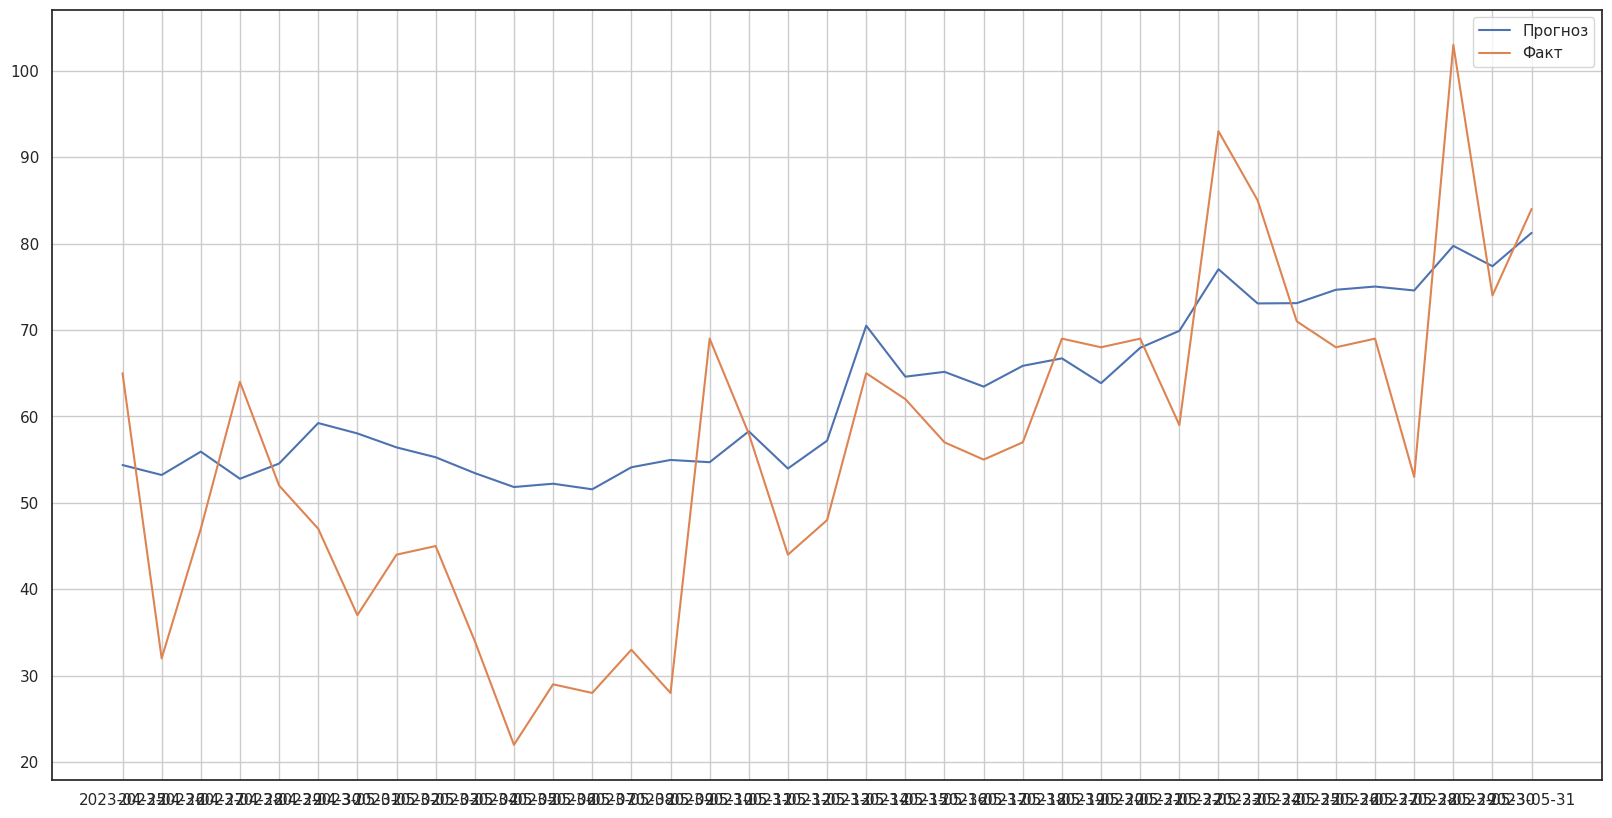

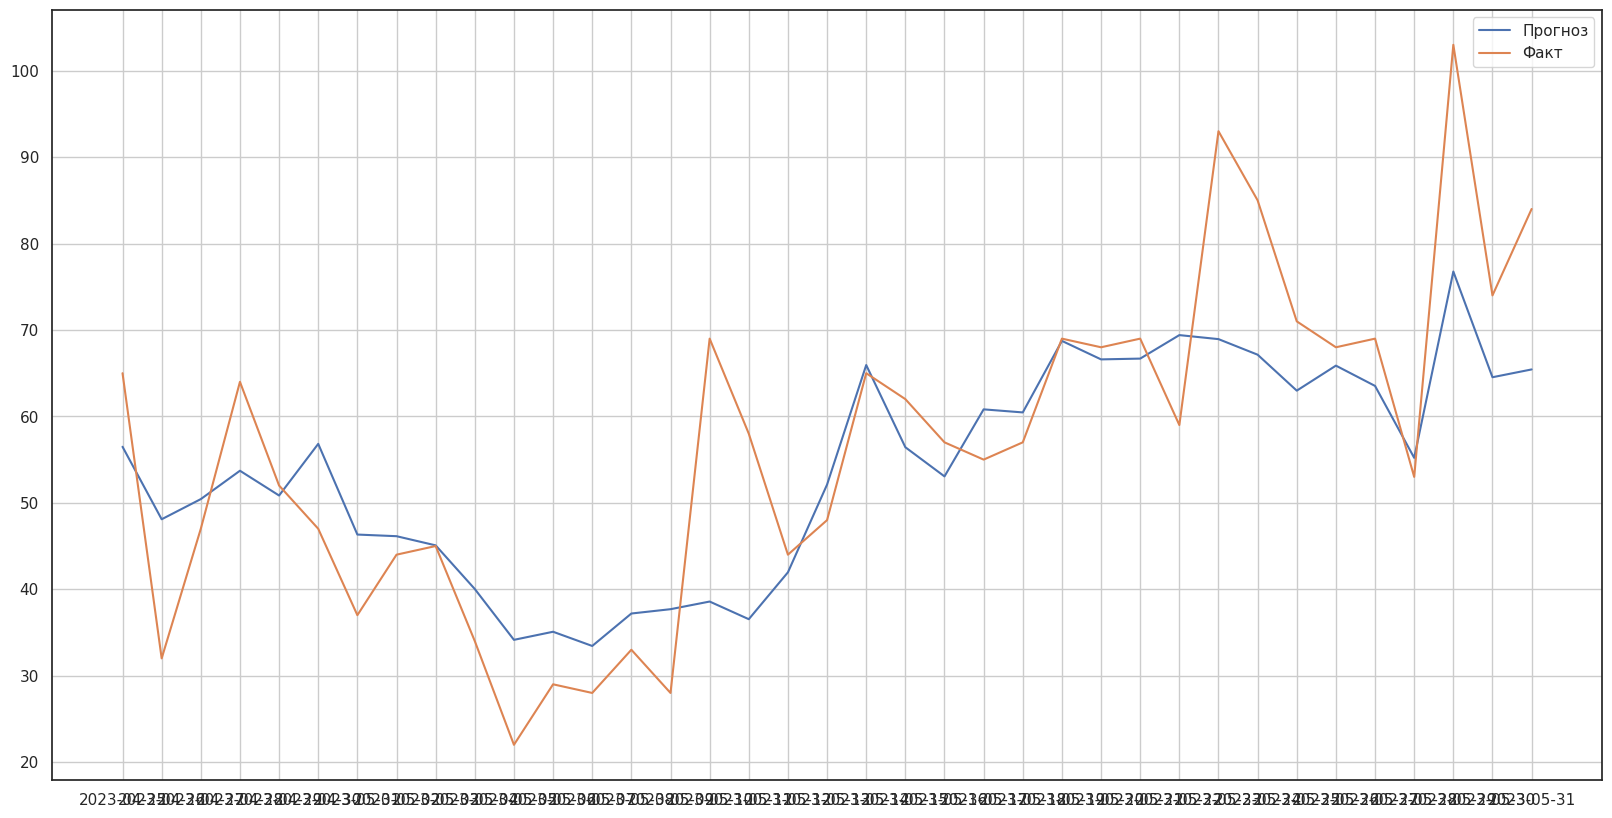

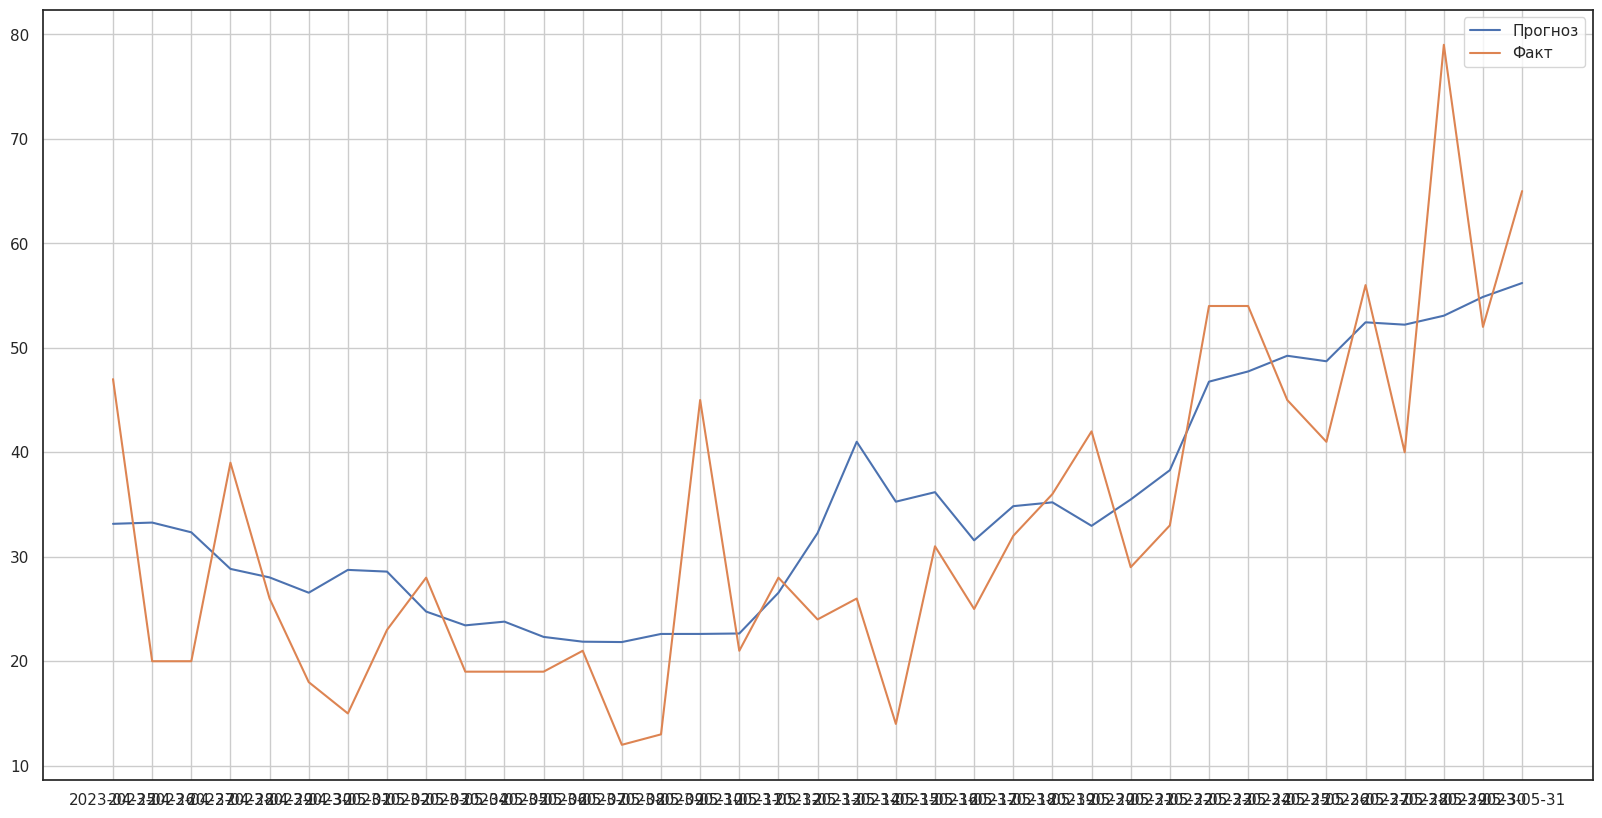

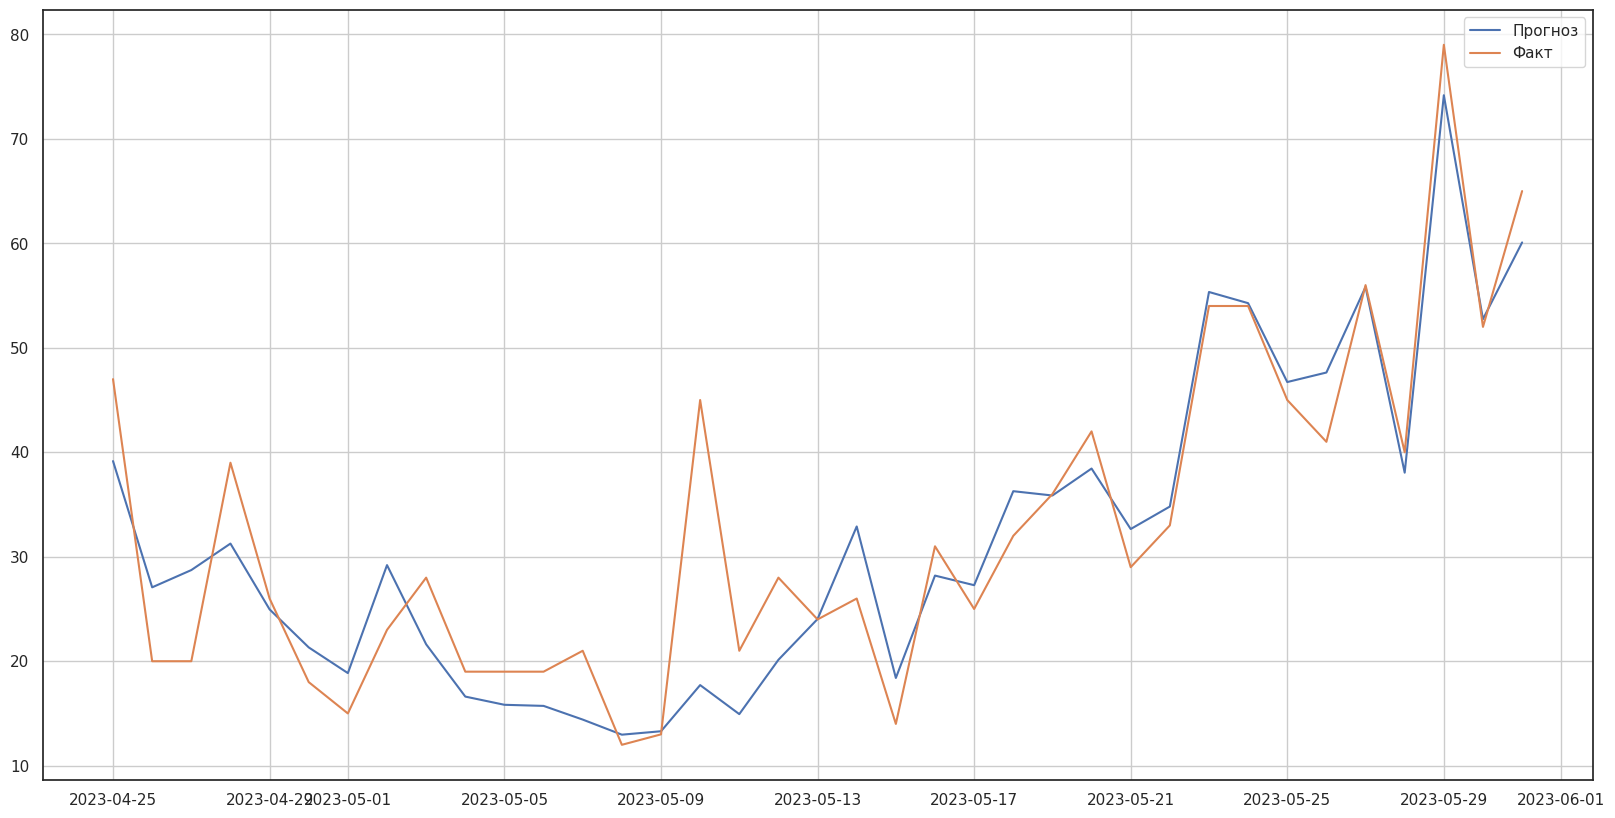

# Тестирование рекомендательной модели

In [ ]:
!pip -q install auto-ts pmdarima --no-deps --ignore-installed

In [ ]:
pip install dill

In [ ]:
import numpy as np
import pandas as pd
from auto_ts import auto_timeseries
from auto_ts import print_ts_model_stats
import matplotlib.pyplot as plt
import dill
import math

In [ ]:
# Для загрузки данных используем drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Загружаем 4 тестовых базы: "Фары с нулями", "Фары без нулей", "Общая с нулями", "Общая без нулей"
df_fara_s0 = pd.read_csv('/content/gdrive/MyDrive/Датясет/my_df_1d_kat_fara_s0.csv')
df_fara_bez0 = pd.read_csv('/content/gdrive/MyDrive/Датясет/my_df_1d_kat_fara.csv')
df_all_s0 = pd.read_csv('/content/gdrive/MyDrive/Датясет/my_df_1d_all_kat_s0.csv')
df_all_bez0 = pd.read_csv('/content/gdrive/MyDrive/Датясет/my_df_1d_kat_all_bez0.csv')

In [ ]:
df_fara_s0.head(2)

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано на сумму,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,2022-06-01,3102,179,4648,294,2228,44,24500,6,122.403981,4083.333333,24.583333
1,2022-06-02,3152,170,4419,246,2416,36,14850,5,243.314023,2970.000000,26.500000


In [ ]:
df_fara_bez0.head(2)

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано на сумму,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,2022-06-01,615,44,1059,86,458,18,24500,6,66.584214,4083.333333,24.583333
1,2022-06-02,696,38,1026,47,521,14,14850,5,395.898541,2970.000000,26.500000


In [ ]:
df_all_s0.head(2)

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Заказано на сумму,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,2022-06-01,5603,278,8275,448,3940,30300,7,138.948980,4328.571429,21.071429
1,2022-06-02,5346,261,7216,385,3939,15840,6,196.629992,2640.000000,22.083333


In [ ]:
df_all_bez0.head(2)

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано на сумму,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,2022-06-01,643,49,1161,114,476,22,30300,7,72.299433,4328.571429,21.071429
1,2022-06-02,701,39,1041,49,525,16,15840,6,393.106933,2640.000000,22.083333


In [ ]:
#Загружаем 4 предобученные модели для каждой базы: "Фары с нулями", "Фары без нулей", "Общая с нулями", "Общая без нулей"
with open('sarima_1D_Fara_s0.pkl', 'rb') as f:
  model_fara_s0 = dill.load(f)
with open('sarima_1D_Fara_bez0.pkl', 'rb') as f:
  model_fara_bez0 = dill.load(f)
with open('sarima_1D_all_s0.pkl', 'rb') as f:
  model_all_s0 = dill.load(f)
with open('sarima_1D_all_bez0.pkl', 'rb') as f:
  model_all_bez0 = dill.load(f)

# 1. Модель с выборкой по Фарам с нулями в заказах

In [ ]:
#Создаем тестовую выборку с минимальным количеством метрик
df_fara_s0.drop(['День', 'Уникальные посетители, всего', 'Уникальные посетители с просмотром карточки товара',
                 'Показы в поиске и каталоге', 'В корзину, всего', 'Заказано на сумму',], axis=1, inplace=True)
df_fara_s0.head(2)

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,4648,294,6,122.403981,4083.333333,24.583333
1,4419,246,5,243.314023,2970.000000,26.500000


In [ ]:
#Создаем прежнюю выборку для сравнения
train1, val1 = df_fara_s0.iloc[:-37], df_fara_s0.iloc[-37:]

In [ ]:
#Запускаем обученную модель
predict_fara_s0 = model_fara_s0.predict(val1, model='auto_SARIMAX', simple=False)['yhat'].values

Predicting using test dataframe as input for auto_SARIMAX model


In [ ]:
#Проверяем полученные метрики оценки точности предсказания
mape = np.mean(np.abs((val1['Заказано товаров'] - predict_fara_s0) / val1['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((val1['Заказано товаров'] - predict_fara_s0)**2))
mape_sum = np.abs((val1['Заказано товаров'].sum() - predict_fara_s0.sum()) / val1['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за 37 дней:", val1['Заказано товаров'].sum())
print("Прогноз за 37 дней:", predict_fara_s0.sum())

RMSE: 10.910879449472564
MAPE: 26.716397628199378
MAPE_sum: 12.832548788270445
Факт за 37 дней: 1211
Прогноз за 37 дней: 1055.597834174045


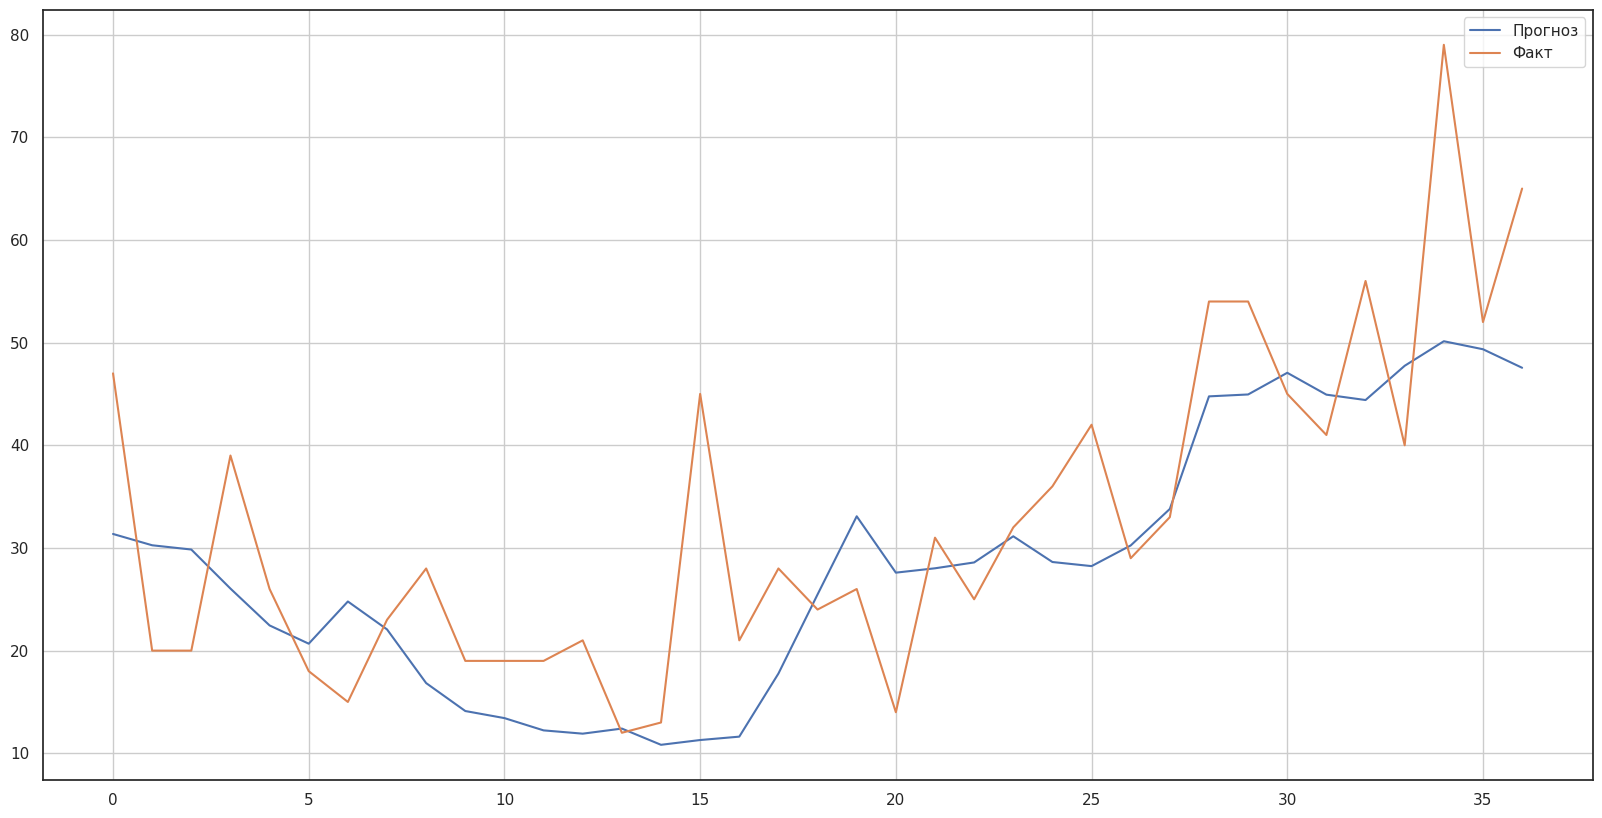

In [ ]:
#Для наглядности строим графики
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(predict_fara_s0)), predict_fara_s0, label='Прогноз')
plt.plot(np.arange(len(predict_fara_s0)), val1['Заказано товаров'].values, label='Факт')
plt.legend()
plt.grid()
plt.show()

Проведем эксперименты, но не на последнем участке Базы (очень резкий взлет), а на умеренном подъеме.

In [ ]:
val1_1 = df_fara_s0.iloc[305:320].copy()

In [ ]:
predict_fara_s0_1 = model_fara_s0.predict(val1_1, model='auto_SARIMAX', simple=False)['yhat'].values

Predicting using test dataframe as input for auto_SARIMAX model


In [ ]:
mape = np.mean(np.abs((val1_1['Заказано товаров'] - predict_fara_s0_1) / val1_1['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((val1_1['Заказано товаров'] - predict_fara_s0_1)**2))
mape_sum = np.abs((val1_1['Заказано товаров'].sum() - predict_fara_s0_1.sum()) / val1_1['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за период:", val1_1['Заказано товаров'].sum())
print("Прогноз за период:", predict_fara_s0_1.sum())

RMSE: 8.200970202451433
MAPE: 18.707114202455934
MAPE_sum: 13.235212232229602
Факт за период: 518
Прогноз за период: 449.44160063705067


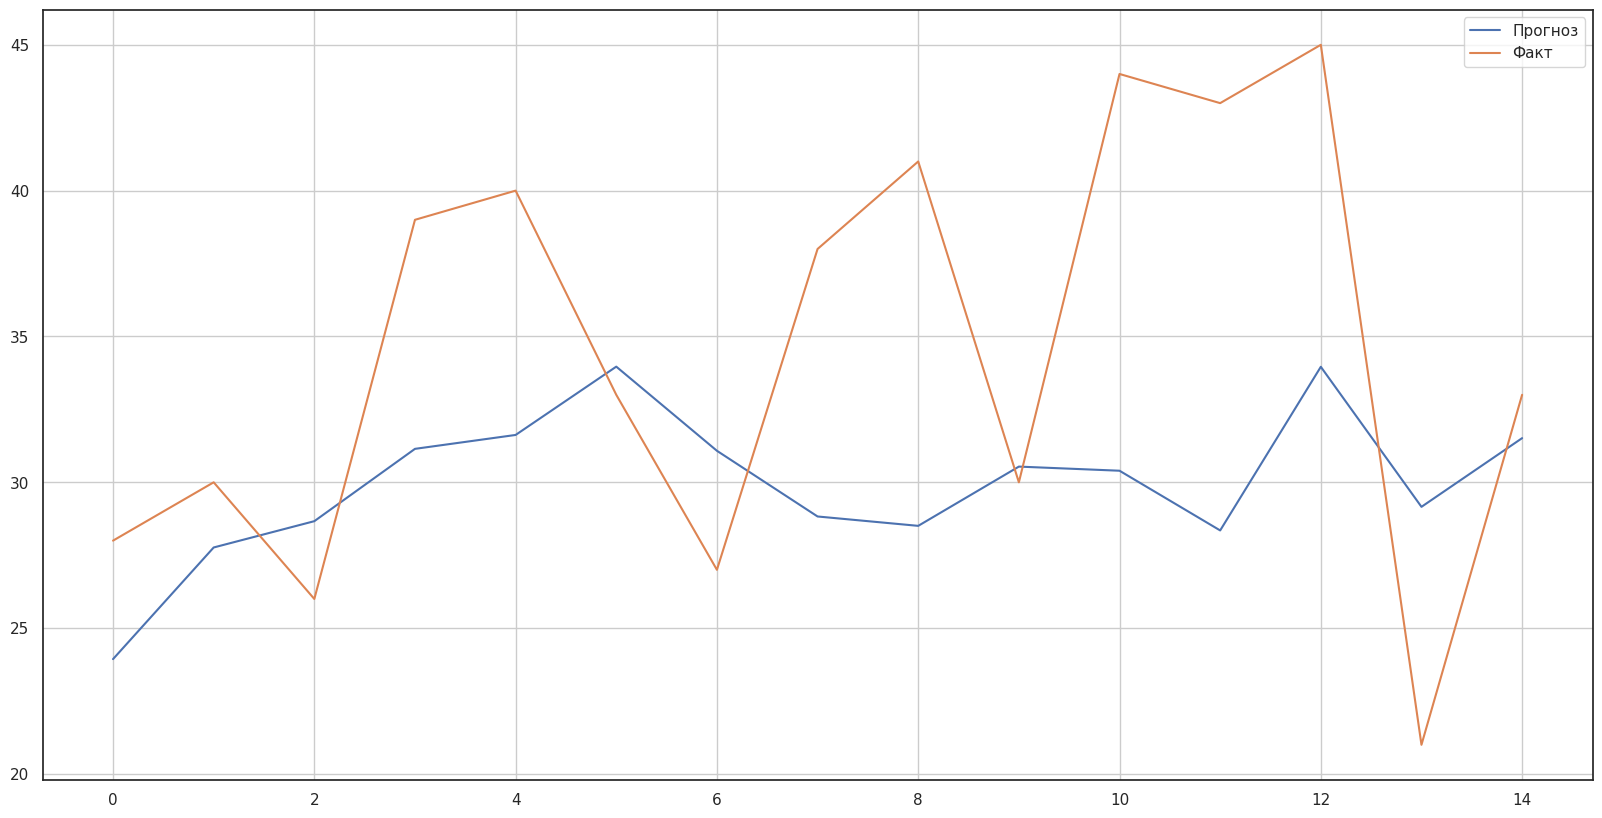

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(predict_fara_s0_1)), predict_fara_s0_1, label='Прогноз')
plt.plot(np.arange(len(predict_fara_s0_1)), val1_1['Заказано товаров'].values, label='Факт')
plt.legend()
plt.grid()
plt.show()

Получим средний день данного периода для наглядности эксперимента.

In [ ]:
sum = pd.DataFrame([val1_1.mean()])
sum.head()

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,36425.933333,1425.4,34.533333,84.522479,3327.078981,22.170992


In [ ]:
predict_fara_s0_1 = model_fara_s0.predict(sum, model='auto_SARIMAX', simple=False)['yhat'].values

Predicting using test dataframe as input for auto_SARIMAX model


In [ ]:
mape = np.mean(np.abs((sum['Заказано товаров'] - predict_fara_s0_1) / sum['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((sum['Заказано товаров'] - predict_fara_s0_1)**2))
mape_sum = np.abs((sum['Заказано товаров'].sum() - predict_fara_s0_1.sum()) / sum['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за период:", sum['Заказано товаров'].sum())
print("Прогноз за период:", predict_fara_s0_1.sum())

RMSE: 5.134262762141276
MAPE: 14.867556261026863
MAPE_sum: 14.867556261026863
Факт за период: 34.53333333333333
Прогноз за период: 29.399070571192055


Мы знаем, что показатели Цены, Позиции в поиске и Контент рейтинга в данной модели имеют слабое влияние на Заказы, в виду отсутствия необходимых данных влияющих на эти показатели. Поэтому изменять будем Показы.

In [ ]:
sum[['Показы, всего', 'Показы на карточке товара']] = sum[['Показы, всего', 'Показы на карточке товара']].mul(1.5)
sum.head()

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,54638.9,2138.1,34.533333,84.522479,3327.078981,22.170992


In [ ]:
predict_fara_s0_1 = model_fara_s0.predict(sum, model='auto_SARIMAX', simple=False)['yhat'].values
predict_fara_s0_1

Predicting using test dataframe as input for auto_SARIMAX model


array([42.32866866])

Вывод:

Возможная ошибка прогноза - 13%

При дневном увеличении на всех товарах группы "Фары" метрики "Показы, всего" на 18213 и соответственно метрики "Показы на карточке товара" на 713 ожидается прирост в заказах за месяц в среднем на 388 штук, что соответствует приросту оборота группы на 1 290 574 рубля.

# 2. Модель с выборкой по Фарам без нулей в заказах

In [ ]:
#Создаем тестовую выборку с минимальным количеством метрик
df_fara_bez0.drop(['День', 'Уникальные посетители, всего', 'Уникальные посетители с просмотром карточки товара',
                 'Показы в поиске и каталоге', 'В корзину, всего', 'Заказано на сумму',], axis=1, inplace=True)

train2, val2 = df_fara_bez0.iloc[:-37], df_fara_bez0.iloc[-37:]

predict_fara_bez0 = model_fara_bez0.predict(val2, model='auto_SARIMAX', simple=False)['yhat'].values

mape = np.mean(np.abs((val2['Заказано товаров'] - predict_fara_bez0) / val2['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((val2['Заказано товаров'] - predict_fara_bez0)**2))
mape_sum = np.abs((val2['Заказано товаров'].sum() - predict_fara_bez0.sum()) / val2['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за 37 дней:", val2['Заказано товаров'].sum())
print("Прогноз за 37 дней:", predict_fara_bez0.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 6.371414791963998
MAPE: 16.92867015646392
MAPE_sum: 0.38426250201716217
Факт за 37 дней: 1211
Прогноз за 37 дней: 1215.6534188994278


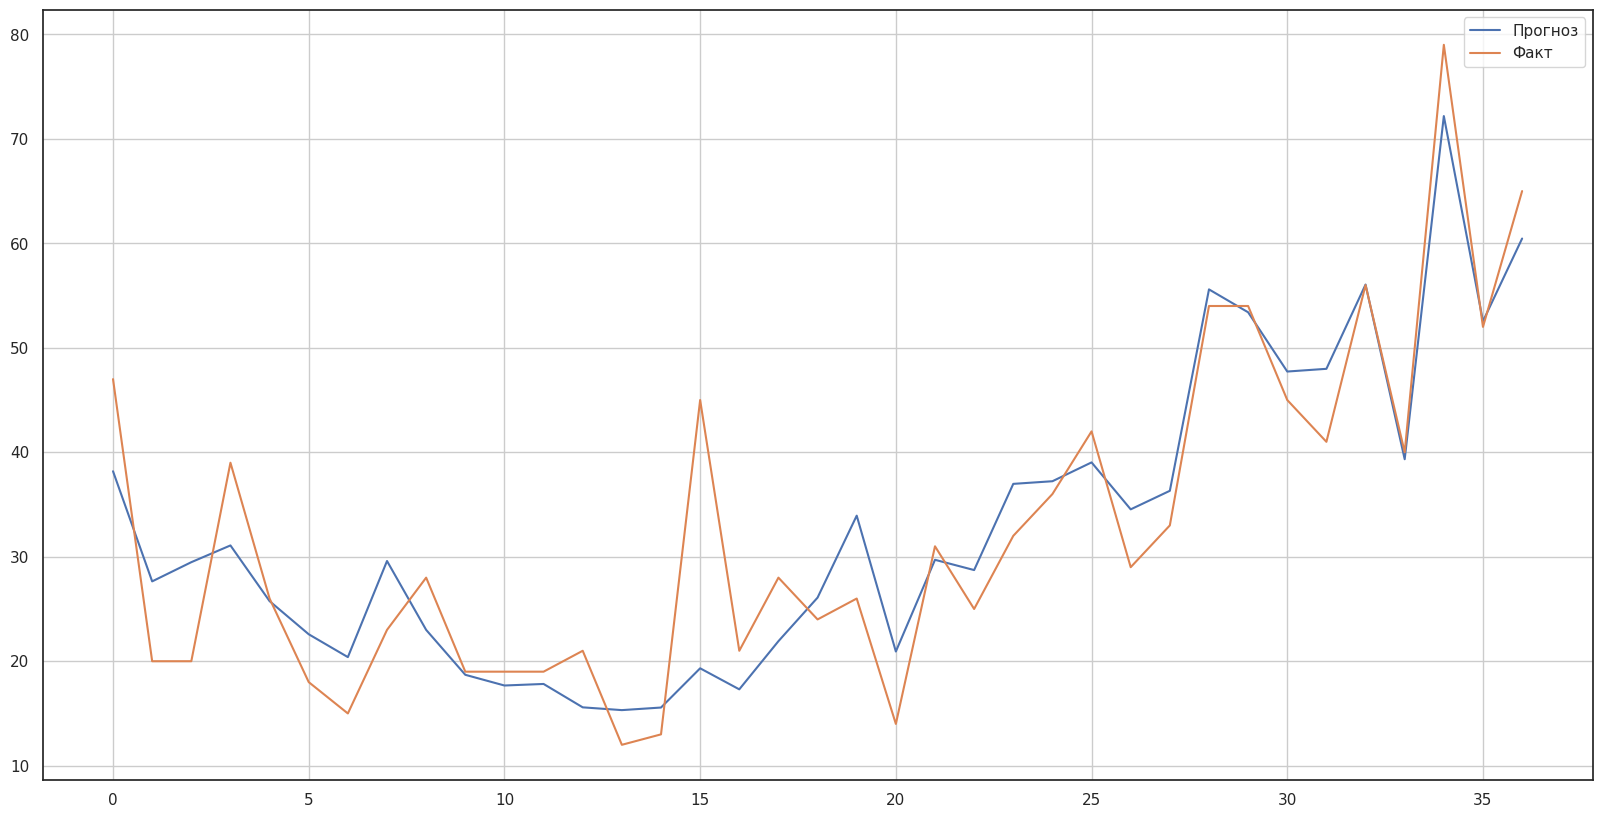

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(predict_fara_bez0)), predict_fara_bez0, label='Прогноз')
plt.plot(np.arange(len(predict_fara_bez0)), val2['Заказано товаров'].values, label='Факт')
plt.legend()
plt.grid()
plt.show()

Проведем эксперименты, но не на последнем участке Базы (очень резкий взлет), а на умеренном подъеме.

In [ ]:
val2_1 = df_fara_bez0.iloc[305:320].copy()
predict_fara_bez0_1 = model_fara_bez0.predict(val2_1, model='auto_SARIMAX', simple=False)['yhat'].values
mape = np.mean(np.abs((val2_1['Заказано товаров'] - predict_fara_bez0_1) / val2_1['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((val2_1['Заказано товаров'] - predict_fara_bez0_1)**2))
mape_sum = np.abs((val2_1['Заказано товаров'].sum() - predict_fara_bez0_1.sum()) / val2_1['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за период:", val2_1['Заказано товаров'].sum())
print("Прогноз за период:", predict_fara_bez0_1.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 4.781617902341809
MAPE: 12.398118968750474
MAPE_sum: 1.3078567020360665
Факт за период: 518
Прогноз за период: 524.7746977165468


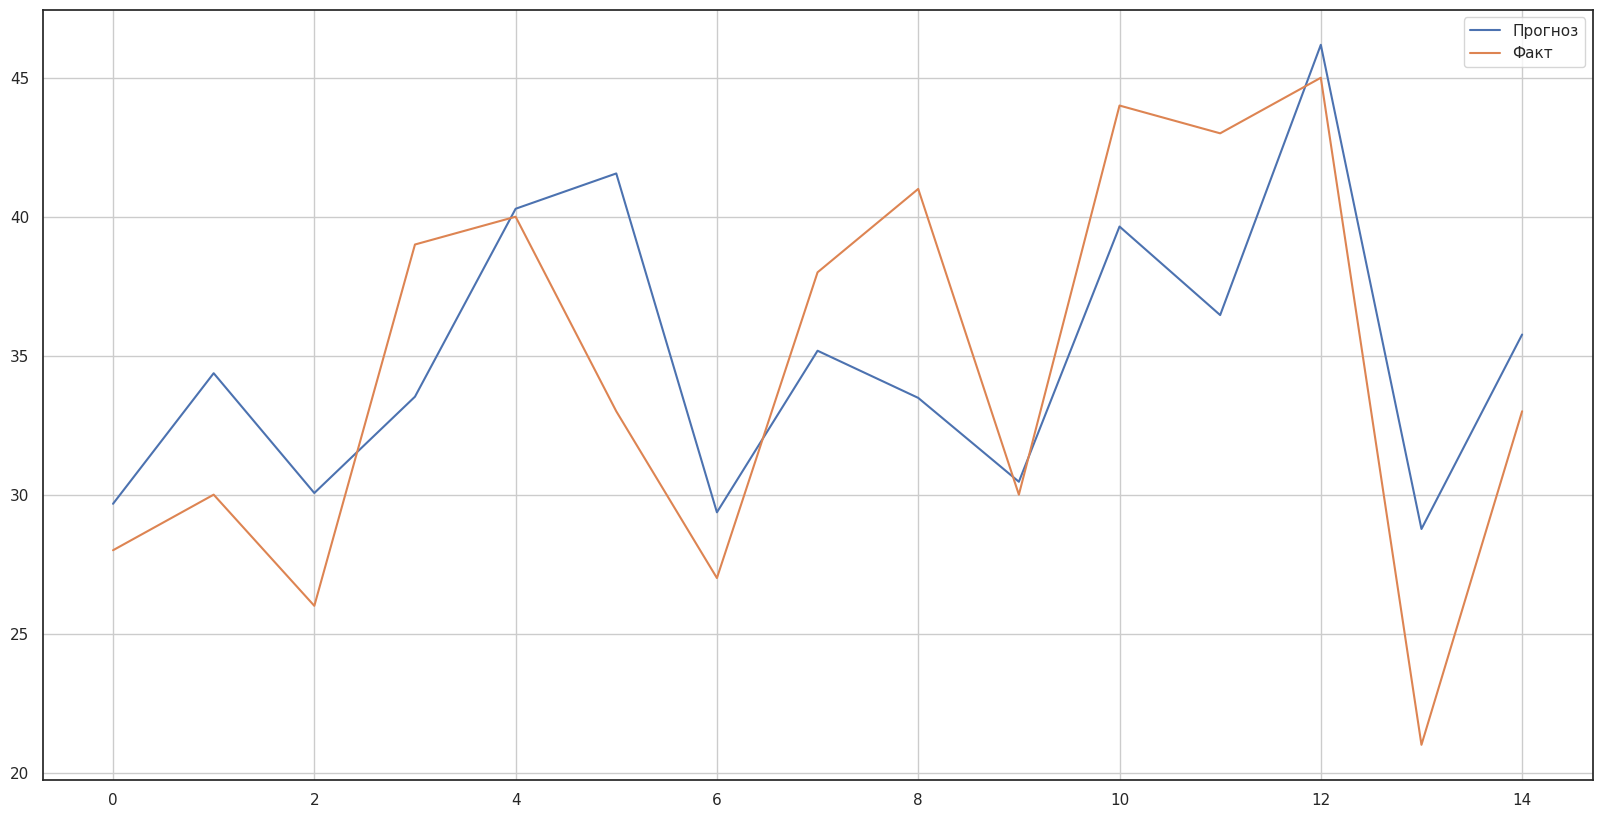

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(predict_fara_bez0_1)), predict_fara_bez0_1, label='Прогноз')
plt.plot(np.arange(len(predict_fara_bez0_1)), val2_1['Заказано товаров'].values, label='Факт')
plt.legend()
plt.grid()
plt.show()

Получим средний день данного периода для упрощения эксперимента.

In [ ]:
sum2 = pd.DataFrame([val2_1.mean()])
sum2.head()

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,11309.333333,554.4,34.533333,78.279692,3327.078981,22.170992


In [ ]:
predict_fara_bez0_1 = model_fara_bez0.predict(sum2, model='auto_SARIMAX', simple=False)['yhat'].values
mape = np.mean(np.abs((sum2['Заказано товаров'] - predict_fara_bez0_1) / sum2['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((sum2['Заказано товаров'] - predict_fara_bez0_1)**2))
mape_sum = np.abs((sum2['Заказано товаров'].sum() - predict_fara_bez0_1.sum()) / sum2['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за период:", sum2['Заказано товаров'].sum())
print("Прогноз за период:", predict_fara_bez0_1.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 0.3443661481022815
MAPE: 0.9971992705664522
MAPE_sum: 0.9971992705664522
Факт за период: 34.53333333333333
Прогноз за период: 34.18896718523105


Мы знаем, что показатели Цены, Позиции в поиске и Контент рейтинга в данной модели имеют слабое влияние на Заказы, в виду отсутствия необходимых данных влияющих на эти показатели. Поэтому изменять будем Показы.

In [ ]:
sum2[['Показы, всего', 'Показы на карточке товара']] = sum2[['Показы, всего', 'Показы на карточке товара']].mul(1.5)
sum2.head()

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,16964.0,831.6,34.533333,78.279692,3327.078981,22.170992


In [ ]:
predict_fara_bez0_1 = model_fara_bez0.predict(sum2, model='auto_SARIMAX', simple=False)['yhat'].values
predict_fara_bez0_1

Predicting using test dataframe as input for auto_SARIMAX model


array([45.45586025])

Вывод:

Возможная ошибка прогноза - 1%

На всех "продаваемых" товарах группы "Фары", при дневном увеличении метрики "Показы, всего" на 5655 и соответственно метрики "Показы на карточке товара" на 277 ожидается прирост в заказах за месяц в среднем на 330 штук, что соответствует приросту оборота группы на 1 097 910 рублей.

# 3. Модель с выборкой по всей группе с нулями в заказах

In [ ]:
#Создаем тестовую выборку с минимальным количеством метрик
df_all_s0.drop(['День', 'Уникальные посетители, всего', 'Уникальные посетители с просмотром карточки товара',
                 'Показы в поиске и каталоге', 'Заказано на сумму',], axis=1, inplace=True)

train3, val3 = df_all_s0.iloc[:-37], df_all_s0.iloc[-37:]

predict_all_s0 = model_all_s0.predict(val3, model='auto_SARIMAX', simple=False)['yhat'].values

mape = np.mean(np.abs((val3['Заказано товаров'] - predict_all_s0) / val3['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((val3['Заказано товаров'] - predict_all_s0)**2))
mape_sum = np.abs((val3['Заказано товаров'].sum() - predict_all_s0.sum()) / val3['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за 37 дней:", val3['Заказано товаров'].sum())
print("Прогноз за 37 дней:", predict_all_s0.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 12.783994518166162
MAPE: 15.541264872378138
MAPE_sum: 5.672869952699897
Факт за 37 дней: 2087
Прогноз за 37 дней: 1968.6072040871531


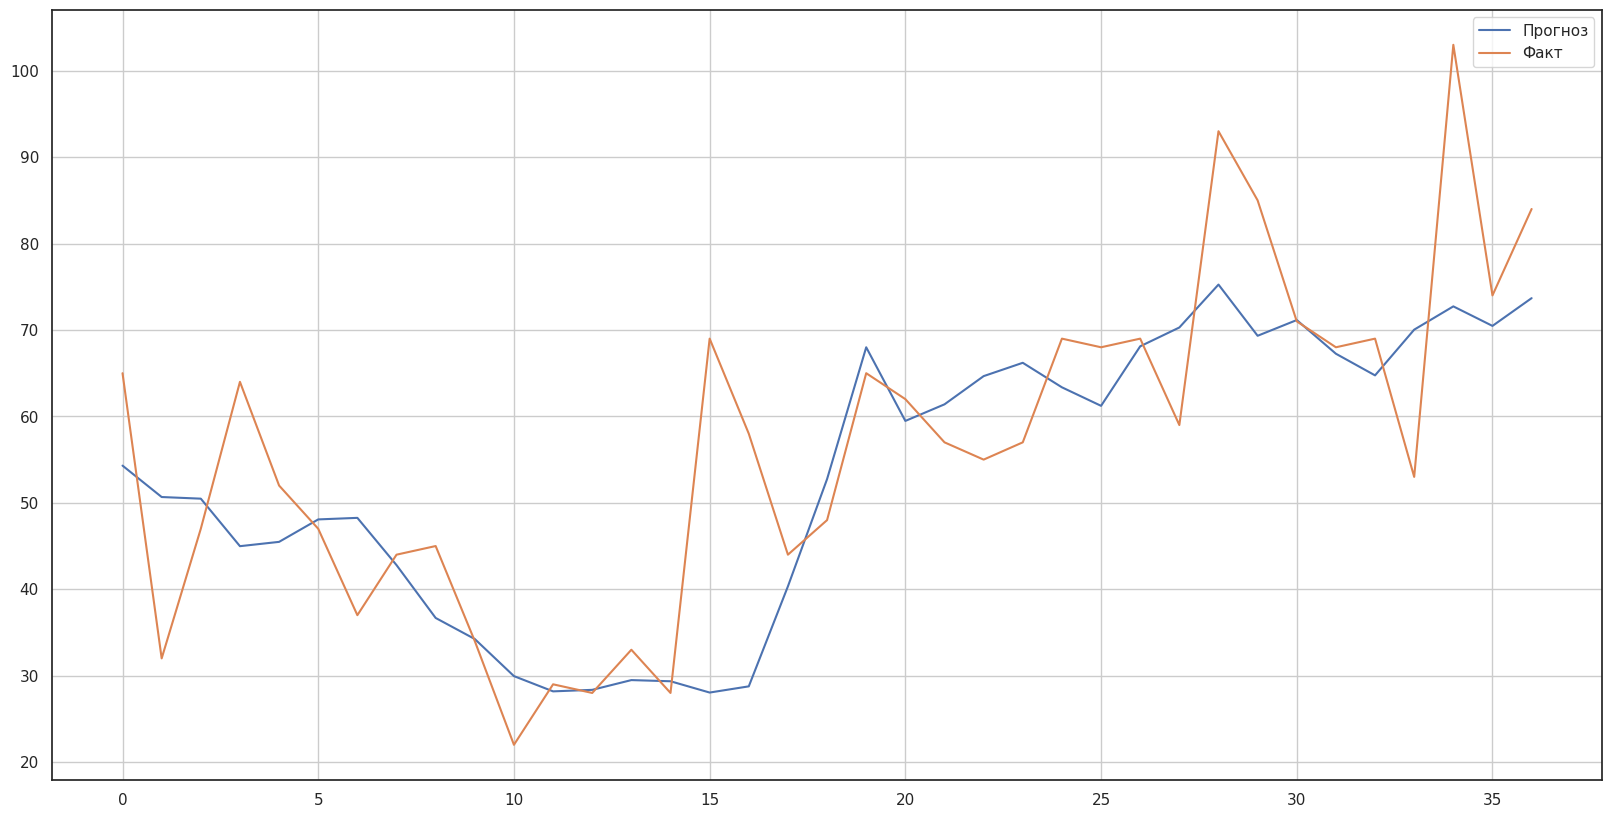

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(predict_all_s0)), predict_all_s0, label='Прогноз')
plt.plot(np.arange(len(predict_all_s0)), val3['Заказано товаров'].values, label='Факт')
plt.legend()
plt.grid()
plt.show()

Проведем эксперименты, но не на последнем участке Базы (очень резкий взлет), а на умеренном подъеме.

In [ ]:
val3_1 = df_all_s0.iloc[305:320].copy()
predict_all_s0_1 = model_all_s0.predict(val3_1, model='auto_SARIMAX', simple=False)['yhat'].values
mape = np.mean(np.abs((val3_1['Заказано товаров'] - predict_all_s0_1) / val3_1['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((val3_1['Заказано товаров'] - predict_all_s0_1)**2))
mape_sum = np.abs((val3_1['Заказано товаров'].sum() - predict_all_s0_1.sum()) / val3_1['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за период:", val3_1['Заказано товаров'].sum())
print("Прогноз за период:", predict_all_s0_1.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 9.377950072016759
MAPE: 17.20502933209471
MAPE_sum: 1.5984124184936765
Факт за период: 788
Прогноз за период: 800.5954898577302


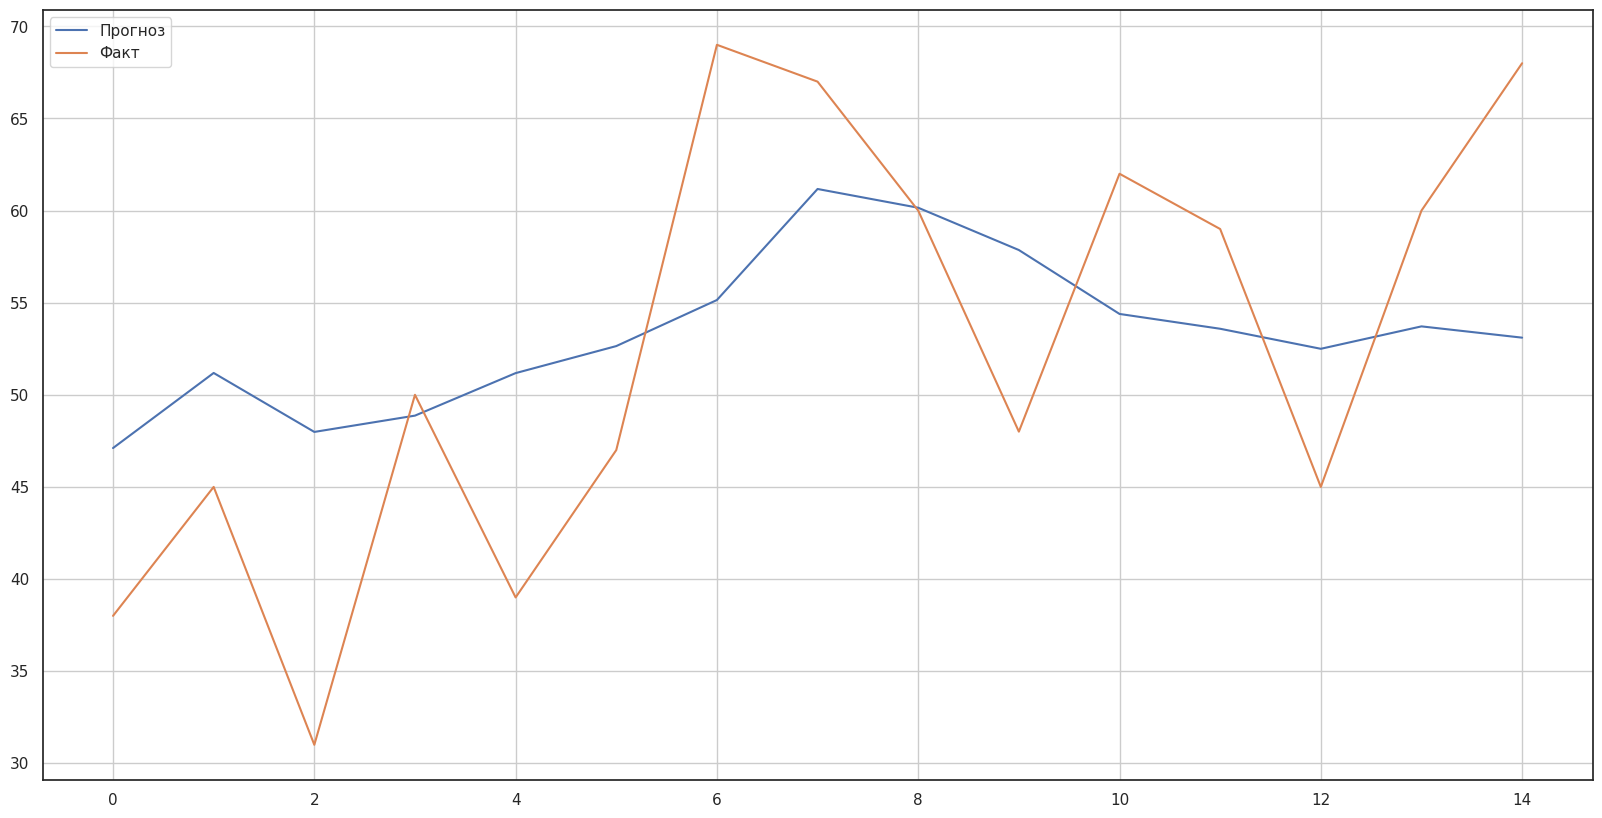

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(predict_all_s0_1)), predict_all_s0_1, label='Прогноз')
plt.plot(np.arange(len(predict_all_s0_1)), val3_1['Заказано товаров'].values, label='Факт')
plt.legend()
plt.grid()
plt.show()

Получим средний день данного периода для наглядности эксперимента.

In [ ]:
sum3 = pd.DataFrame([val3_1.mean()])
sum3.head()

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,72339.2,2808.133333,52.533333,78.757784,3146.861229,20.419678


In [ ]:
predict_all_s0_1 = model_all_s0.predict(sum3, model='auto_SARIMAX', simple=False)['yhat'].values
mape = np.mean(np.abs((sum3['Заказано товаров'] - predict_all_s0_1) / sum3['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((sum3['Заказано товаров'] - predict_all_s0_1)**2))
mape_sum = np.abs((sum3['Заказано товаров'].sum() - predict_all_s0_1.sum()) / sum3['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за период:", sum3['Заказано товаров'].sum())
print("Прогноз за период:", predict_all_s0_1.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 2.159506877195895
MAPE: 4.110736441362745
MAPE_sum: 4.110736441362745
Факт за период: 52.53333333333333
Прогноз за период: 50.37382645613744


Мы знаем, что показатели Цены, Позиции в поиске и Контент рейтинга в данной модели имеют слабое влияние на Заказы, в виду отсутствия необходимых данных влияющих на эти показатели. Поэтому изменять будем Показы.

In [ ]:
sum3[['Показы, всего', 'Показы на карточке товара']] = sum3[['Показы, всего', 'Показы на карточке товара']].mul(1.5)
sum3.head()

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,108508.8,4212.2,52.533333,78.757784,3146.861229,20.419678


In [ ]:
predict_all_s0_1 = model_all_s0.predict(sum3, model='auto_SARIMAX', simple=False)['yhat'].values
predict_all_s0_1

Predicting using test dataframe as input for auto_SARIMAX model


array([65.26163998])

Вывод:

Возможная ошибка прогноза - 5,6%

На всех товарах всех групп, при дневном увеличении метрики "Показы, всего" на 36 169 и соответственно метрики "Показы на карточке товара" на 1 404 ожидается прирост в заказах за месяц в среднем на 450 штук, что соответствует приросту оборота на 4 418 191 рубль.

# 4. Модель с выборкой по всей группе без нулей в заказах

In [ ]:
#Создаем тестовую выборку с минимальным количеством метрик
df_all_bez0.drop(['День', 'Уникальные посетители, всего', 'Уникальные посетители с просмотром карточки товара',
                 'Показы в поиске и каталоге', 'В корзину, всего', 'Заказано на сумму',], axis=1, inplace=True)

train4, val4 = df_all_bez0.iloc[:-37], df_all_bez0.iloc[-37:]

predict_all_bez0 = model_all_bez0.predict(val4, model='auto_SARIMAX', simple=False)['yhat'].values

mape = np.mean(np.abs((val4['Заказано товаров'] - predict_all_bez0) / val4['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((val4['Заказано товаров'] - predict_all_bez0)**2))
mape_sum = np.abs((val4['Заказано товаров'].sum() - predict_all_bez0.sum()) / val4['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за 37 дней:", val4['Заказано товаров'].sum())
print("Прогноз за 37 дней:", predict_all_bez0.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 11.319311139707537
MAPE: 15.845092942112277
MAPE_sum: 4.203755198918739
Факт за 37 дней: 2087
Прогноз за 37 дней: 1999.267628998566


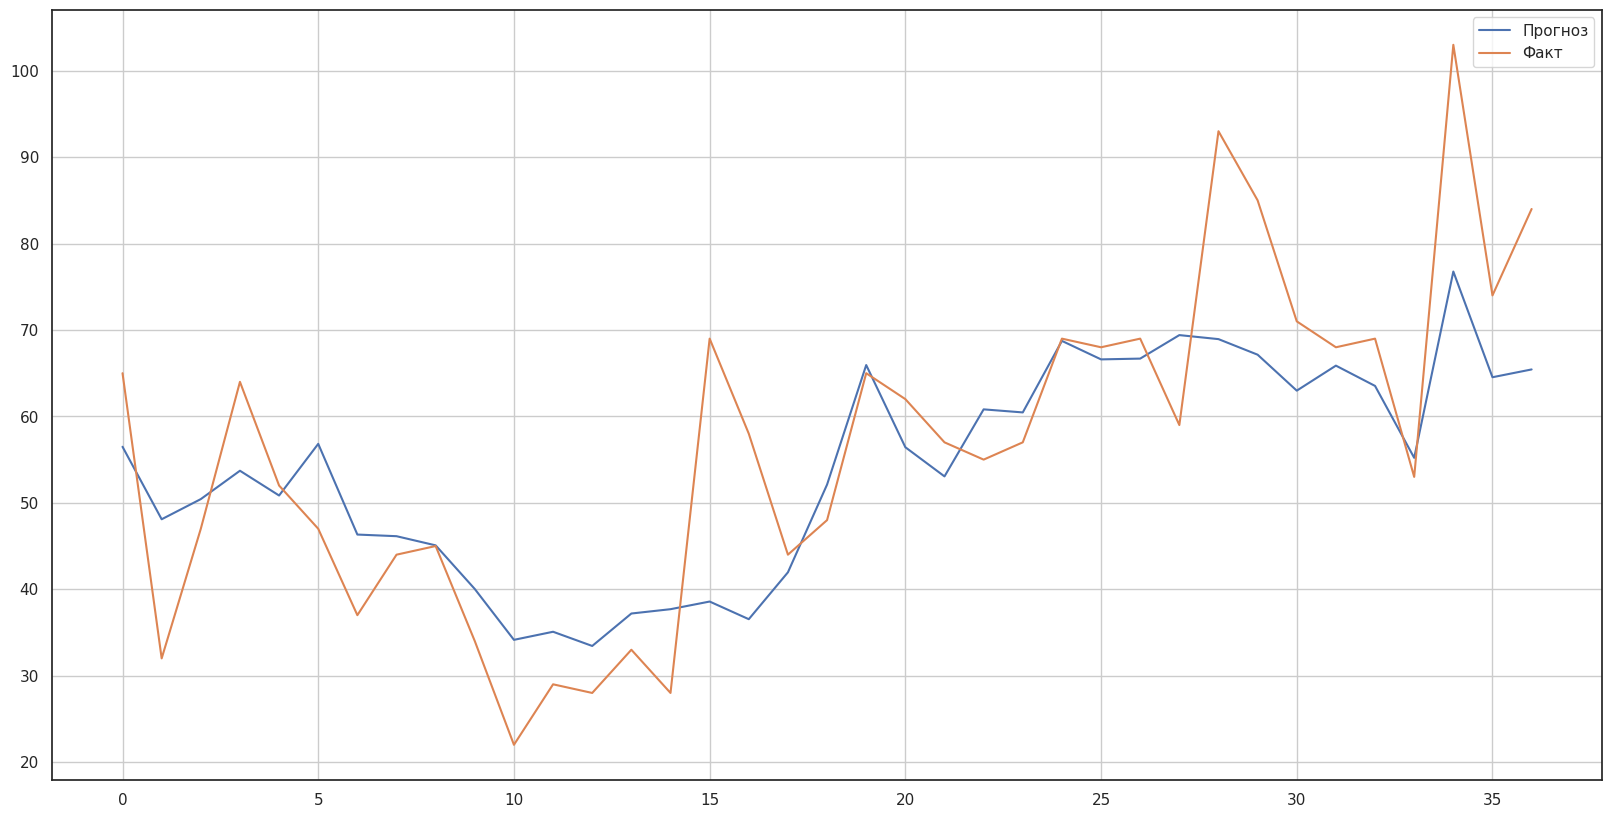

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(predict_all_bez0)), predict_all_bez0, label='Прогноз')
plt.plot(np.arange(len(predict_all_bez0)), val4['Заказано товаров'].values, label='Факт')
plt.legend()
plt.grid()
plt.show()

Проведем эксперименты, но не на последнем участке Базы (очень резкий взлет), а на умеренном подъеме.

In [ ]:
val4_1 = df_all_bez0.iloc[305:320].copy()
predict_all_bez0_1 = model_all_bez0.predict(val4_1, model='auto_SARIMAX', simple=False)['yhat'].values
mape = np.mean(np.abs((val4_1['Заказано товаров'] - predict_all_bez0_1) / val4_1['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((val4_1['Заказано товаров'] - predict_all_bez0_1)**2))
mape_sum = np.abs((val4_1['Заказано товаров'].sum() - predict_all_bez0_1.sum()) / val4_1['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за период:", val4_1['Заказано товаров'].sum())
print("Прогноз за период:", predict_all_bez0_1.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 8.08477365504164
MAPE: 12.027717336440679
MAPE_sum: 4.799509293600974
Факт за период: 826
Прогноз за период: 786.356053234856


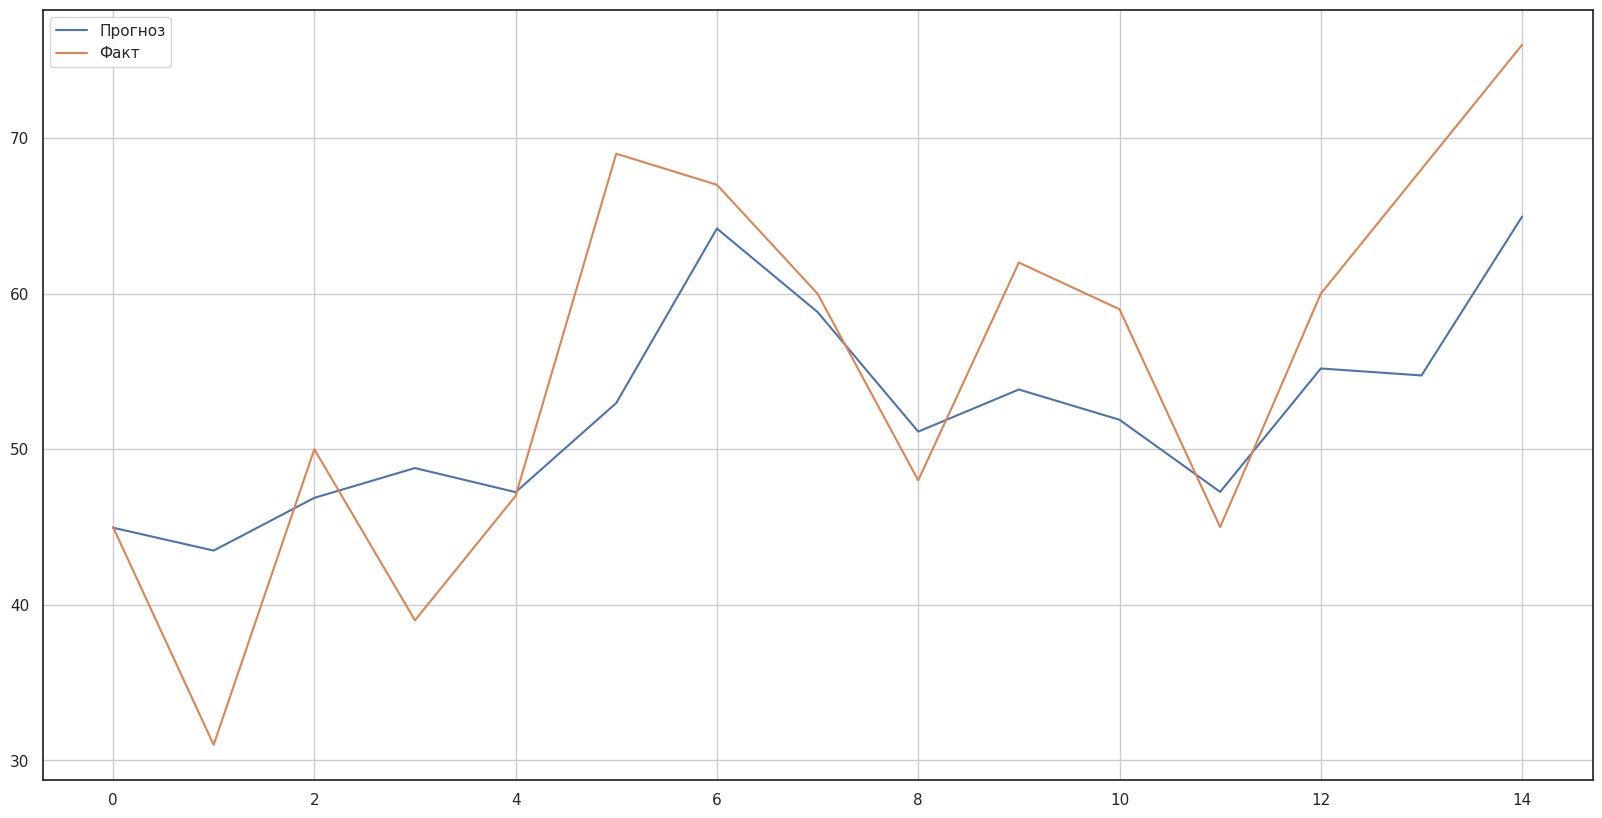

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(predict_all_bez0_1)), predict_all_bez0_1, label='Прогноз')
plt.plot(np.arange(len(predict_all_bez0_1)), val4_1['Заказано товаров'].values, label='Факт')
plt.legend()
plt.grid()
plt.show()

Получим средний день данного периода для наглядности эксперимента.

In [ ]:
sum4 = pd.DataFrame([val4_1.mean()])
sum4.head()

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,20580.333333,1064.666667,55.066667,66.606468,3155.524387,20.408713


In [ ]:
predict_all_bez0_1 = model_all_bez0.predict(sum4, model='auto_SARIMAX', simple=False)['yhat'].values
mape = np.mean(np.abs((sum4['Заказано товаров'] - predict_all_bez0_1) / sum4['Заказано товаров'])) * 100
rmse = np.sqrt(np.mean((sum4['Заказано товаров'] - predict_all_bez0_1)**2))
mape_sum = np.abs((sum4['Заказано товаров'].sum() - predict_all_bez0_1.sum()) / sum4['Заказано товаров'].sum()) * 100
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAPE_sum:", mape_sum)
print("Факт за период:", sum4['Заказано товаров'].sum())
print("Прогноз за период:", predict_all_bez0_1.sum())

Predicting using test dataframe as input for auto_SARIMAX model
RMSE: 4.31464558240323
MAPE: 7.835312800974388
MAPE_sum: 7.835312800974388
Факт за период: 55.06666666666667
Прогноз за период: 50.75202108426344


Мы знаем, что показатели Цены, Позиции в поиске и Контент рейтинга в данной модели имеют слабое влияние на Заказы, в виду отсутствия необходимых данных влияющих на эти показатели. Поэтому изменять будем Показы.

In [ ]:
sum4[['Показы, всего', 'Показы на карточке товара']] = sum4[['Показы, всего', 'Показы на карточке товара']].mul(1.5)
sum4.head()

,"Показы, всего",Показы на карточке товара,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,30870.5,1597.0,55.066667,66.606468,3155.524387,20.408713


In [ ]:
predict_all_bez0_1 = model_all_bez0.predict(sum4, model='auto_SARIMAX', simple=False)['yhat'].values
predict_all_bez0_1

Predicting using test dataframe as input for auto_SARIMAX model


array([61.82544776])

Вывод:

Возможная ошибка прогноза - 7,8%

На всех "продаваемых" товарах всех групп, при дневном увеличении метрики "Показы, всего" на 10 300 и соответственно метрики "Показы на карточке товара" на 533 ожидается прирост в заказах за месяц в среднем на 330 штук, что соответствует приросту оборота группы на 1 041 321 рубль.

### **Итог**

Полученные результаты нельзя понимать буквально как руководство к действию, они лишь на цыфрах доказывают логические выводы сделаные ранее. Дают правильное понимание ситуации и помогают выбрать нужное напрвление для развития данного проека.

Полная модель прогнозирования "Заказов" должна состоять из следующих блоков:

  1. Ежедневное количество посетителей и совершенных ими заказов в категории дадут возможность на временной модели предсказывать объем продаж в категории и количество посетителей.
      
  (Сколько приходит каждый день Посетителей в категорию)

  2. Ежедневное количество показов и позиция в поиске товара всех продавцов категории дадут возможность предсказывать распределение показов товара посетителям в нутри категории.
  
  (Сколько каждый день Посетителей из п.1 увидят твой товар)

  3. Ежедневное изменение цены товара и контент рейтинга всех продавцов категории дадут возможность предсказывать о принятии решения Заказать товар.
  
  (Сколько каждый день Посетителей из п.2 Закажут твой товар)

  

**В данной модели будут ясны причины распределения всей воронки продаж и возможность влиять на каждый показатель на любом этапе.**

**Что доступно сейчас и что можно применить.**

1. Анализ на "проданных" товарах показал самую высокую точность, т.к. для прогнозирования есть данные влияющие на "Заказы" в достаточном объеме. Эта модель прогнозирует "Заказы" в идеальных условиях, когда клиент не может уйти к конкурентам.
На сколько к этим данным можно приблизится можно понять, проанализировав данные конкурентов в данной категории.

2. При прогнозировании на всей базе точность падает, т.к. нет возможности учесть причины случаев когда "Заказ" не сделан. Но модель все таки пытается при анализе исключить варианты без Заказов, о чем говорят результаты влияния, они соразмерны с идеальным предсказанием.

    2.1 Возможные причины, когда "нулевой" заказ: не устроила цена, плохие отзывы, не правильное описание.
    
    2.2 Влияя на каждую причину можно увеличивать "Заказы" не увеличивая Показов, лиш повышая конверсию.

3. На имеющихся данных можно делать прогноз лишь влияя на один показатель Показы (Просмотры), расчеты приведены.


4. Получение дополнительного трафика возможно через "Платное продвижение в поиске" на Озоне, в самом сервисе в зависимости от ставки дается прогноз показов товара, который можно применять в модели прогнозирования. Остальные данные подаваемые в модель (Позиция в поиске и каталоге средняя;	Цена товара средняя;	Контент-рейтинг средний) менее динамичные и могут задаваться с учетом предполагаемых изменений или по фактическому значению.
    
    Формировать собственный трафик через альтернативные каналы продвижения возможно так же с использованием нейронных сетей, но это отдельная тема не связанная с нашим заданием.

Проверять прогноз на всех товарах нет смысла, т.к. оплачивать "Продвижение" всех товаров очень дорого.

Оптимальным будет использовать АВС анализ проведенный ранеею Выбрать группу товаров А или АВ, обучить на этих товарах модель и сделать прогноз в продажах с учетом увеличения Показов.


Определить влияние на Заказы изменением (наполняемостью) карточки товара и цены нет возможности, необходимо проводить анализ экспертным путем с помощью аналитиков.

Логично при продвижении и увеличении продаж будет расти Позиция в поиске и частота показов будет расти естественным способом, модель обученная на статичных данных начнет сильнее ошибаться.

**В этих условиях необходимо заново обучать модель на новых данных каждый месяц для сохранения точности.**

**Выводы:**

 -  Технически делать прогноз на 1, 3 и 6 месяцев для "ГалогенаНЕТ" **есть**, но смысла в нем нет. (не достаточно данных и точность на 3 и 6 месяцев будет не приемлемой) Максимум на 1 мес.
 -  Давать прогноз новому клиенту в категории Автосвет, на данных "ГалогенаНЕТ" **можно**. Максимум на 1 мес.
 -  Давать прогноз клиентам из других категорий с наличием аналогичной базы "ГалогенаНЕТ" **можно** с горизонтом 1 месяц.
 -  Давать прогноз новому клиенту в других категориях, из-за отсутствия данных **нельзя**. (не достаточно данных)
 -  Давать прогноз относительно кор цены **нельзя**. (не достаточно данных)
 -  Давать прогноз относительно заполненности карточки и ключевых слов должен делать SEO аналитик 1-2 раза в год, на анализе данных продаж такой прогноз **не построить**. (другой тип данных)
 -  Необходимо решить проблему достоверности данных МПСТАТС и для создания модели прогнозирования категории нужны метрики (Показы, всего; Показы на карточке товара;	Заказано товаров; Позиция в поиске и каталоге средняя; Цена товара средняя; Контент-рейтинг средний) **всей категории**.